In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Load the final_anomalies dataset (training data)
final_anomalies = pd.read_csv('datasets/final_anomalies.csv')

# Load the sampled dataset (test data)
sampled_data = pd.read_csv('datasets/sampled_data.csv', nrows=10000)

In [3]:
# Check the distribution of the anomaly_normal column
label_distribution = final_anomalies['anomaly_normal'].value_counts()
print(label_distribution)


1.0    362
0.0    329
Name: anomaly_normal, dtype: int64


In [4]:
final_anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Materialnummer            691 non-null    object 
 1   Lieferant OB              691 non-null    float64
 2   Vertrag OB                410 non-null    float64
 3   Vertragsposition OB       691 non-null    float64
 4   Planlieferzeit Vertrag    691 non-null    float64
 5   Vertrag Fix1              691 non-null    int64  
 6   Vertrag_Fix2              691 non-null    int64  
 7   Beschaffungsart           691 non-null    object 
 8   Sonderbeschaffungsart     307 non-null    float64
 9   Disponent                 691 non-null    int64  
 10  Einkäufer                 691 non-null    float64
 11  DispoGruppe               691 non-null    object 
 12  Dispolosgröße             691 non-null    object 
 13  Gesamtbestand             691 non-null    float64
 14  Gesamtwert

In [5]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18676 entries, 0 to 18675
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Materialnummer            18676 non-null  object 
 1   Lieferant OB              18676 non-null  int64  
 2   Vertrag OB                667 non-null    float64
 3   Vertragsposition OB       18676 non-null  int64  
 4   Planlieferzeit Vertrag    18676 non-null  int64  
 5   Vertrag Fix1              18676 non-null  int64  
 6   Vertrag_Fix2              18676 non-null  int64  
 7   Beschaffungsart           18676 non-null  object 
 8   Sonderbeschaffungsart     7430 non-null   float64
 9   Disponent                 18676 non-null  int64  
 10  Einkäufer                 18676 non-null  float64
 11  DispoGruppe               18663 non-null  object 
 12  Dispolosgröße             18676 non-null  object 
 13  Gesamtbestand             18676 non-null  int64  
 14  Gesamt

In [6]:
# Define the features to be used
features = ["Planlieferzeit Vertrag", "Vertrag Fix1", "Vertrag_Fix2", "Gesamtbestand", "Gesamtwert", "Preiseinheit", "WE_Bearbeitungszeit", "Planlieferzeit Mat-Stamm"]

In [7]:
# Rename the column in the test data to match the training data
sampled_data.rename(columns={'WE-Bearbeitungszeit': 'WE_Bearbeitungszeit'}, inplace=True)

In [8]:
# Prepare the training data
X_train = final_anomalies[features]
y_train = final_anomalies['anomaly_normal']

In [9]:
# Prepare the test data
X_test = sampled_data[features]

In [10]:
# Fill missing values (if any) with the mean of the respective column
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [11]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Evaluate on the training set
y_train_pred = rf_model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

Training Accuracy: 0.9088277858176556
Confusion Matrix:
 [[308  21]
 [ 42 320]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       329
         1.0       0.94      0.88      0.91       362

    accuracy                           0.91       691
   macro avg       0.91      0.91      0.91       691
weighted avg       0.91      0.91      0.91       691



In [13]:
# Test on the sampled dataset
y_test_pred = rf_model.predict(X_test)
predictions = pd.DataFrame(y_test_pred, columns=['Predicted_Anomalies'])

In [14]:
# Get the anomaly scores (probabilities) for the test data
anomaly_scores = rf_model.predict_proba(X_test)[:, 0]  # Probability of being an anomaly (class 0)

In [15]:
# Add the anomaly scores as a new column to the test data
sampled_data['Anomaly_Score'] = anomaly_scores

In [16]:
# Save the DataFrame with anomaly scores to a CSV file
sampled_data.to_csv('sampled_data_with_anomaly_scores.csv', index=False)

# Print the first few rows of the DataFrame
print(sampled_data.head())

  Materialnummer  Lieferant OB    Vertrag OB  Vertragsposition OB  \
0     23884900UB        700000           NaN                    0   
1       00360029        701806  5.500001e+09                   10   
2       04002905        706808           NaN                    0   
3       60022412          1000           NaN                    0   
4     01568000UB        700000           NaN                    0   

   Planlieferzeit Vertrag  Vertrag Fix1  Vertrag_Fix2 Beschaffungsart  \
0                       0             0             0               F   
1                       4             4            60               F   
2                       0             0             0               F   
3                       0             0             0               F   
4                       0             0             0               F   

   Sonderbeschaffungsart  Disponent  ...  Kalender Werk OB Werk Infosatz  \
0                    NaN        723  ...       E20    2000           N

In [17]:
# Print the first few predictions
print(predictions.head())

   Predicted_Anomalies
0                  1.0
1                  1.0
2                  0.0
3                  1.0
4                  0.0


In [18]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Scores:", cv_scores.std())


Cross-Validation Scores: [0.49640288 0.71014493 0.72463768 0.5942029  0.37681159]
Mean Cross-Validation Score: 0.5804399958294234
Standard Deviation of Cross-Validation Scores: 0.13140207184648756


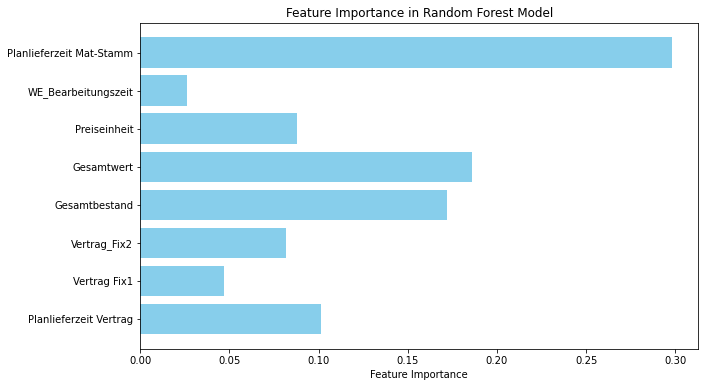

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()

In [20]:
sampled_data = pd.read_csv('sampled_data_with_anomaly_scores.csv')

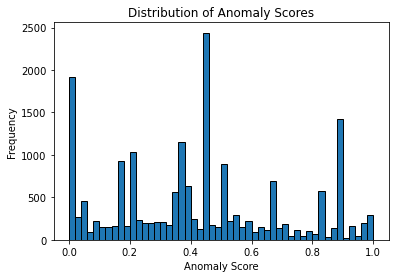

In [21]:
# Analyze the distribution of anomaly scores
plt.hist(sampled_data['Anomaly_Score'], bins=50, edgecolor='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.show()

In [22]:
threshold = 0.5

In [23]:
# Label data based on the threshold
sampled_data['Predicted_Label'] = (sampled_data['Anomaly_Score'] < threshold).astype(int)

# Check the distribution of the predicted labels
label_distribution = sampled_data['Predicted_Label'].value_counts()
print(label_distribution)

1    12236
0     6440
Name: Predicted_Label, dtype: int64


In [24]:
# Save the labeled data to a new CSV file
sampled_data.to_csv('sampled_data_with_anomaly_labels.csv', index=False)

# Print the first few rows of the labeled data
print(sampled_data.head())

  Materialnummer  Lieferant OB    Vertrag OB  Vertragsposition OB  \
0     23884900UB        700000           NaN                    0   
1       00360029        701806  5.500001e+09                   10   
2       04002905        706808           NaN                    0   
3       60022412          1000           NaN                    0   
4     01568000UB        700000           NaN                    0   

   Planlieferzeit Vertrag  Vertrag Fix1  Vertrag_Fix2 Beschaffungsart  \
0                       0             0             0               F   
1                       4             4            60               F   
2                       0             0             0               F   
3                       0             0             0               F   
4                       0             0             0               F   

   Sonderbeschaffungsart  Disponent  ...  Werk OB Werk Infosatz  \
0                    NaN        723  ...     2000           NaN   
1           